In [1]:
import pandas as pd
import dgl
import networkx as nx
from karateclub import FeatherGraph, Graph2Vec, GL2Vec, WaveletCharacteristic

/home/santiagovargas/anaconda3/envs/qtaim_embed/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = "/home/santiagovargas/dev/qtaim_generator/data/xyz/molecule_complete.pkl"
df = pd.read_pickle(file)
names_list = list(df.names)

In [3]:
dict_base = {}
for name in names_list:
    basename = name[:-14]
    # print(basename)
    if basename not in dict_base.keys():
        dict_base[basename] = {"names": [], "graphs": {}}
    dict_base[basename]["names"].append(name)

# sort each list

for keys in dict_base.keys():
    dict_base[keys]["names"].sort()

for keys in dict_base.keys():
    if len(dict_base[keys]["names"]) > 2:
        # remove all but the first and last
        dict_base[keys]["names"] = [
            dict_base[keys]["names"][0],
            dict_base[keys]["names"][-1],
        ]

# filter df to only have rows with names in the list
df = df[
    df.names.isin([item for sublist in dict_base.values() for item in sublist["names"]])
]

In [4]:
def build_graph(row, self_loop=True):
    bonds = list(row["bonds"])
    num_bonds = len(bonds)
    num_atoms = len(row["molecule_graph"])

    a2b = []
    b2a = []
    if num_bonds == 0:
        num_bonds = 1
        a2b = [(0, 0)]
        b2a = [(0, 0)]

    else:
        a2b = []
        b2a = []
        for b in range(num_bonds):
            u = bonds[b][0]
            v = bonds[b][1]
            b2a.extend([[b, u], [b, v]])
            a2b.extend([[u, b], [v, b]])

    a2g = [(a, 0) for a in range(num_atoms)]
    g2a = [(0, a) for a in range(num_atoms)]
    b2g = [(b, 0) for b in range(num_bonds)]
    g2b = [(0, b) for b in range(num_bonds)]

    edges_dict = {
        ("atom", "a2b", "bond"): a2b,
        ("bond", "b2a", "atom"): b2a,
        ("atom", "a2g", "global"): a2g,
        ("global", "g2a", "atom"): g2a,
        ("bond", "b2g", "global"): b2g,
        ("global", "g2b", "bond"): g2b,
    }
    if self_loop:
        a2a = [(i, i) for i in range(num_atoms)]
        b2b = [(i, i) for i in range(num_bonds)]
        g2g = [(0, 0)]
        edges_dict.update(
            {
                ("atom", "a2a", "atom"): a2a,
                ("bond", "b2b", "bond"): b2b,
                ("global", "g2g", "global"): g2g,
            }
        )

    g = dgl.heterograph(edges_dict)
    # add name
    g.mol_name = row["ids"]
    # if mol.original_atom_ind != None:
    #    g.atom_ind = mol.original_atom_ind
    # if mol.original_bond_mapping != None:
    #    g.bond_ind = mol.original_bond_mapping

    return g


def build_networkx_graph(
    row,
    attr_atom=["extra_feat_atom_esp_e", "extra_feat_atom_Lagrangian_K"],
    attr_bond=["extra_feat_bond_esp_e"],
):
    bonds = list(row["bonds"])
    num_bonds = len(bonds)
    num_atoms = len(row["molecule_graph"])

    G = nx.Graph()
    G.add_nodes_from(range(num_atoms))
    G.add_edges_from(bonds)

    def _add_node_attrs(G, attr, attr_ind, val, as_str=False):
        for ind, n in enumerate(G.nodes()):
            if G.nodes[n] == {}:
                G.nodes[n]["feature"] = {}

            if as_str:
                G.nodes[n]["feature"][attr] = float(val[ind])
            else:
                G.nodes[n]["feature"][attr_ind] = float(val[ind])

    def _add_bond_attrs(G, attr, attr_ind, vals, bond_ordering, as_str=False):
        bonds_order_as_tuple = [tuple(b) for b in bond_ordering[0]]
        # zip list of tuples with list vals
        dict_attrs = {
            edge: float(val) for edge, val in zip(bonds_order_as_tuple, vals[0])
        }
        if as_str:
            nx.set_edge_attributes(G, dict_attrs, attr)
        else:
            nx.set_edge_attributes(G, dict_attrs, attr_ind)

    bond_list = row.extra_feat_bond_indices_qtaim
    [
        _add_node_attrs(G, attr, ind + 1, row[attr], as_str=False)
        for ind, attr in enumerate(attr_atom)
    ]

    [
        _add_bond_attrs(G, attr, ind + 1, row[attr], bond_list, as_str=False)
        for ind, attr in enumerate(attr_bond)
    ]

    # show atom atrributes
    print(G.nodes[0])
    print(G.edges[(0, 1)])
    return G


"""def featurize(self, g, row, ret_feat_names=False, **kwargs):
    if self.atom_featurizer is not None:
        feat_dict, feat_atom = self.atom_featurizer(row, **kwargs)
        g.nodes["atom"].data.update(feat_dict)

    if self.bond_featurizer is not None:
        feat_dict, feat_bond = self.bond_featurizer(row, **kwargs)
        g.nodes["bond"].data.update(feat_dict)

    if ret_feat_names:
        feat_names = {}
        feat_names["atom"] = [feat_atom]
        feat_names["bond"] = [feat_bond]
        return g, feat_names

    return g"""

'def featurize(self, g, row, ret_feat_names=False, **kwargs):\n    if self.atom_featurizer is not None:\n        feat_dict, feat_atom = self.atom_featurizer(row, **kwargs)\n        g.nodes["atom"].data.update(feat_dict)\n\n    if self.bond_featurizer is not None:\n        feat_dict, feat_bond = self.bond_featurizer(row, **kwargs)\n        g.nodes["bond"].data.update(feat_dict)\n\n    if ret_feat_names:\n        feat_names = {}\n        feat_names["atom"] = [feat_atom]\n        feat_names["bond"] = [feat_bond]\n        return g, feat_names\n\n    return g'

In [5]:
dgl_test = build_graph(df.iloc[0])
nx_test = build_networkx_graph(df.iloc[0])

{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}


In [6]:
# feather - uses node features
# graph2vec - can be attributed
# GL2Vec -can take node-level features
# Wavelet - uses node features

In [7]:
nx_graphs_non_attr = [
    build_networkx_graph(row, attr_atom=[], attr_bond=[]) for i, row in df.iterrows()
]
nx_graphs_attr = [build_networkx_graph(row) for i, row in df.iterrows()]

{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}
{'feature': {1: -694.0230222, 2: 286822171.20000005}}
{1: -170.5283626}


In [8]:
# import mean squared error
from sklearn.metrics import mean_squared_error

models = [FeatherGraph(), Graph2Vec(), WaveletCharacteristic()]
for model in models:
    model.fit(nx_graphs_non_attr)
    X_non = model.get_embedding()
    model.fit(nx_graphs_attr)
    X_attr = model.get_embedding()
    print("rmse non attr", mean_squared_error(X_non, X_non))

rmse non attr 0.0
rmse non attr 0.0
rmse non attr 0.0


In [9]:
features = nx.get_node_attributes(nx_graphs_attr[0], "feature")
for node in nx_graphs_attr[0].nodes():
    nebs = nx_graphs_attr[0].neighbors(node)
    degs = [features[neb] for neb in nebs]

In [10]:
from karateclub.utils.treefeatures import WeisfeilerLehmanHashing

WeisfeilerLehmanHashing(
    graph=nx_graphs_attr[0], wl_iterations=2, attributed=True, erase_base_features=False
)

In [11]:
model = Graph2Vec(attributed=True)
model.fit(nx_graphs_attr)
X = model.get_embedding()

In [12]:
GL2Vec = Graph2Vec(attributed=True)
GL2Vec.fit(nx_graphs_attr)
X = GL2Vec.get_embedding()

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
# x_mani = TSNE(n_components=2, perplexity=).fit_transform(X)

[1.58207044e-01 1.34318843e-01 1.22978434e-01 1.19704649e-01
 1.10156767e-01 9.56119150e-02 9.27518830e-02 9.19782072e-02
 7.42923021e-02 2.03103953e-15]


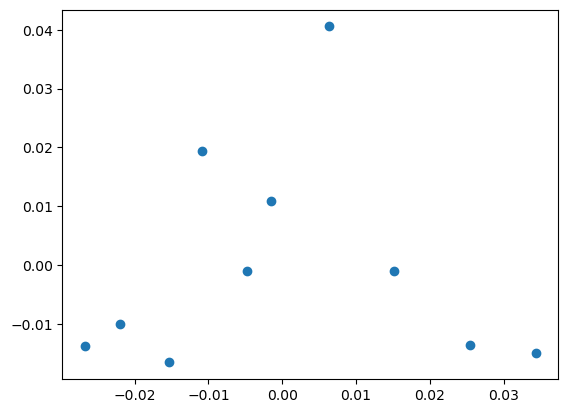

In [14]:
# plot
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

In [18]:
import umap

x_trans = umap.UMAP(n_neighbors=2).fit_transform(X)

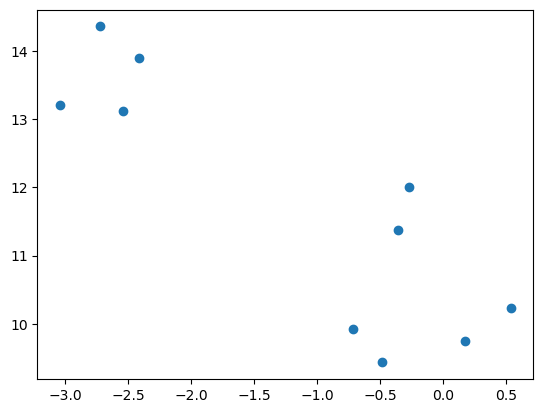

In [20]:
plt.scatter(x_trans[:, 0], x_trans[:, 1])
plt.show()